In [1]:
# Makes print and division act like Python 3
from __future__ import print_function, division

# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

from IPython.display import display, Latex, clear_output
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
import pynrc
from pynrc import nrc_utils
from pynrc.nrc_utils import S
from pynrc.obs_nircam import model_to_hdulist
pynrc.setup_logging('WARNING', verbose=False)

In [77]:
from pynrc.nrc_utils import pad_or_cut_to_size

# Circular Masks

In [3]:
fov_pix = 65
oversample = 2

psf_info={'fov_pix':fov_pix, 'oversample':oversample,
          'save':False, 'force':True, 'jitter':None}


In [4]:
cf_ote = nrc_utils.psf_coeff('F444W', **psf_info)
psf_ote, psf_ote_over = nrc_utils.gen_image_coeff('F444W', coeff=cf_ote, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [5]:
cf_off = nrc_utils.psf_coeff('F444W', 'CIRCLYOT', **psf_info)
psf_off, psf_off_over = nrc_utils.gen_image_coeff('F444W', 'CIRCLYOT', coeff=cf_off, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [6]:
cf_cen = nrc_utils.psf_coeff('F444W', pupil='CIRCLYOT', mask='MASK335R', **psf_info)
psf_cen, psf_cen_over = nrc_utils.gen_image_coeff('F444W', 'CIRCLYOT', 'MASK335R', coeff=cf_cen, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [7]:
fov_asec = fov_pix*nrc_utils.pixscale_LW
pixscale = nrc_utils.pixscale_LW / oversample

In [8]:
shift_array = np.arange(0,63,3)
shift_asec = shift_array * pixscale

In [9]:
def mshift(mask, shift_array):
    
    masks = []
    for shift in shift_array:
        mask_shift = nrc_utils.fshift(mask, delx=-shift)
        mask_cut = nrc_utils.pad_or_cut_to_size(mask_shift, psf_ote_over.shape)
        masks.append(mask_cut)
    return masks

In [10]:
mask = nrc_utils.coron_trans('MASK335R', fov=2*fov_asec, pixscale=pixscale)
masks = mshift(mask, shift_array)

In [11]:
shift_array

array([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48,
       51, 54, 57, 60])

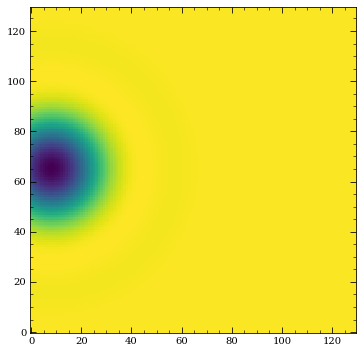

In [12]:
plt.imshow(masks[-2])

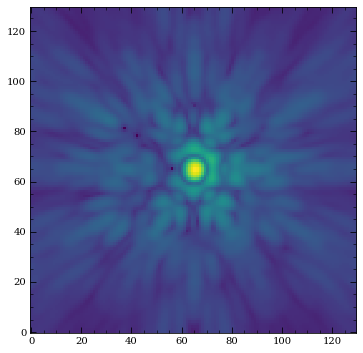

In [13]:
plt.imshow((psf_ote_over*masks[3])**0.2)

In [14]:
psf_list = []
psf_over_list = []
for i, offset in enumerate(shift_asec):
    print(shift_array[i])
    nrc = pynrc.NIRCam('F444W', pupil='CIRCLYOT', mask='MASK335R',
                       offset_r=offset, offset_theta=-90, 
                       fov_pix=2*fov_pix+1, oversample=2,
                       force=True, save=False)
    psf0, psf1 = nrc.gen_psf(return_oversample=True)
    psf_list.append(psf0)
    psf_over_list.append(psf1)

0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60


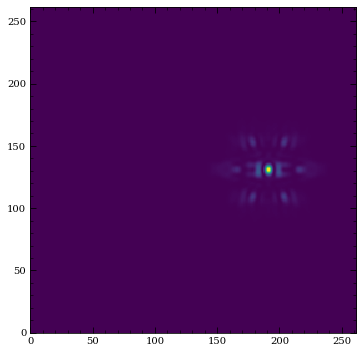

In [15]:
plt.imshow(psf_over_list[-1])

In [16]:
for i, psf in enumerate(psf_over_list):
    psf_list[i] = nrc_utils.fshift(psf_list[i], delx=-shift_array[i]/2)
    psf_over_list[i] = nrc_utils.fshift(psf_over_list[i], delx=-shift_array[i]*oversample/2)

In [17]:
masks[0].shape

(130, 130)

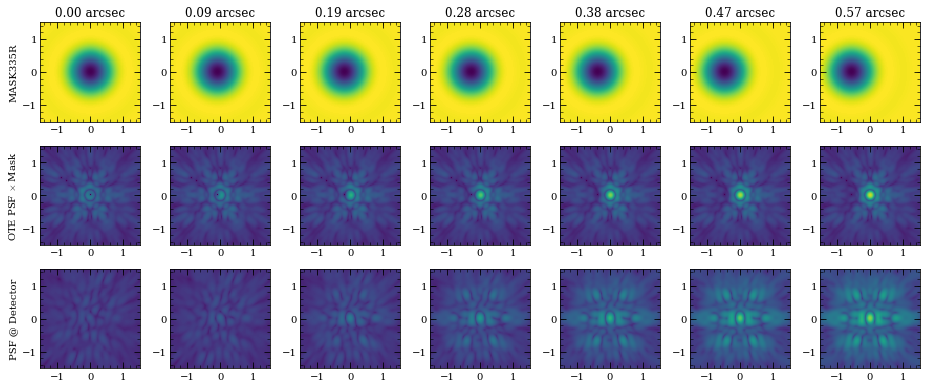

In [18]:
fig, axes = plt.subplots(3, 7, figsize=(13,5.5))

extent = np.array([-1,1,-1,1])*pixscale*masks[0].shape[0]/2
xylim = [-1.5,1.5]
for i, ax in enumerate(axes[0]):
    ax.imshow(masks[i], extent=extent)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel('MASK335R')
    ax.set_title('{:.2f} arcsec'.format(shift_asec[i]))

extent = np.array([-1,1,-1,1])*pixscale*psf_ote_over.shape[0]/2
for i, ax in enumerate(axes[1]):
    ax.imshow((masks[i]*psf_ote_over)**0.2, extent=extent, vmin=0, vmax=psf_ote_over.max()**0.2)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel(r'OTE PSF $\times$ Mask ')

extent = np.array([-1,1,-1,1])*pixscale*psf_over_list[0].shape[0]/2
for i, ax in enumerate(axes[2]):
    ax.imshow((psf_over_list[i]**0.2), extent=extent, vmin=0, vmax=psf_off_over.max()**0.2)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel('PSF @ Detector')

fig.tight_layout()

outdir = '/Users/Jarron/Desktop/JWST-PP/'
#fig.savefig(outdir+'M335R_PSF_offset.pdf')

In [96]:
from pynrc.maths.image_manip import align_LSQ, fourier_imshift, fshift

In [ ]:
from scipy.optimize import leastsq, least_squares
def f(x, a, b):
    return a*x[0] + b*x[1]

def residual(p, x, y):
    return (y - f(x, *p)).ravel()

In [19]:
nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)

xdata = np.array([psf_off_over, psf_cen_over]) * 1e5

avals = []
bvals = []
for i, psf in enumerate(psf_over_list):
    #print(shift_array[i])
    #ydata = fshift(psf, -0.00957687, -0.01525233)
    ydata = nrc_utils.pad_or_cut_to_size(psf, psf_off_over.shape) * 1e5

    res_best = [0,0]
    chi_fin = 1e10
    a0 = np.interp(shift_array[i], xv, mask[nx//2,:]**2)
    b0 = 1-a0

    for a0 in np.linspace(0,1,10):
        b0 = 1-a0

        res = least_squares(residual, [a0,b0], args=(xdata, ydata), diff_step=0.1, 
                            loss='soft_l1', f_scale=1.0, bounds=([0,0],[1,1]))
        chi_new = np.sum((ydata - f(xdata, *res.x))**2)
        if chi_new < chi_fin:
            chi_fin = chi_new
            res_best = res.x

#    ymod = f(xdata, *res_best)
#    diff = ydata - ymod
#    diff_rebin = nrc_utils.frebin(ydata, scale=1/oversample) - nrc_utils.frebin(ymod, scale=1/oversample)
#    print(np.abs(diff_rebin**2).sum(), np.abs(diff_rebin).max())

    
    ymod = f(xdata, *res_best) / 1e5
    ydata /= 1e5
    diff = ydata - ymod

    ydata_rebin = nrc_utils.frebin(ydata, scale=1/oversample)
    ymod_rebin = nrc_utils.frebin(ymod, scale=1/oversample)

    pnoise = np.sqrt(ymod_rebin)
    ind = ymod_rebin>0

    
    diff_rebin = ymod_rebin - ydata_rebin
    chi1 = np.sum((diff_rebin[ind])**2 / ymod_rebin[ind])
    chi2 = np.sum(diff_rebin[ind]**2 / pnoise[ind]**2)
    
    
    print(shift_array[i], chi1, chi2/ymod_rebin.sum(), np.abs(diff_rebin).max(), res_best)


    
    avals.append(res_best[0])
    bvals.append(res_best[1])

0 1.26657587454e-08 8.32428795904e-06 1.46072305181e-08 [  1.57138233e-07   9.99951312e-01]
3 4.82571390306e-05 0.0273633767059 1.15333875805e-06 [ 0.0014631   0.99947474]
6 0.000224659116852 0.0661017441924 3.80524542106e-06 [ 0.0113124  1.       ]
9 0.000393451913305 0.0460755824143 8.21238092903e-06 [ 0.04229234  1.        ]
12 0.000453194708106 0.023321470331 1.44106818243e-05 [ 0.10794088  1.        ]
15 0.000421678368618 0.0113868973697 2.03243640396e-05 [ 0.21471024  0.92301443]
18 0.000340684292547 0.00564626721141 2.38030217861e-05 [ 0.35719922  0.70120489]
21 0.000257371511673 0.00296690814558 2.35861742226e-05 [ 0.51872915  0.4424762 ]
24 0.000198200419087 0.00175902460379 2.35741695391e-05 [ 0.67723707  0.19753228]
27 0.000166665209124 0.00123594518561 2.38932757945e-05 [ 0.81262101  0.00526235]
30 0.000157435895625 0.00104025722273 2.21276583901e-05 [  9.12076175e-01   1.04522374e-13]
33 0.000156991767767 0.000972331567564 1.99621432772e-05 [  9.73039759e-01   6.50569613e-

In [29]:
nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)

xdata = np.array([psf_off_over, psf_cen_over])

for i, psf in enumerate(psf_over_list):
    #print(shift_array[i])
    #ydata = fshift(psf, -0.00957687, -0.01525233)
    ydata = nrc_utils.pad_or_cut_to_size(psf, psf_off_over.shape)

    res_best = [0,0]
    chi_fin = 1e10
    a0 = np.interp(shift_array[i], xv, mask[nx//2,:]**2)
    b0 = 1-np.interp(shift_array[i], xv, mask[nx//2,:]**4)
    
    res_best = (a0, b0)
    ymod = f(xdata, *res_best)
    diff = ydata - ymod

    ydata_rebin = nrc_utils.frebin(ydata, scale=1/oversample)
    ymod_rebin = nrc_utils.frebin(ymod, scale=1/oversample)

    pnoise = np.sqrt(ymod_rebin)
    ind = ymod_rebin>0

    
    diff_rebin = ymod_rebin - ydata_rebin
    chi1 = np.sum((diff_rebin[ind])**2 / ymod_rebin[ind])
    chi2 = np.sum(diff_rebin[ind]**2 / pnoise[ind]**2)
    
    
    print(shift_asec[i], chi1, chi2/ymod_rebin.sum(), np.abs(diff_rebin).max(), res_best)


0.0 1.26666456781e-08 8.32460821003e-06 1.46079393866e-08 (0.0, 1.0)
0.0945 8.51030624928e-05 0.0526341855543 3.90517795376e-06 (0.0005742570266868354, 0.9999996702288673)
0.189 0.000331551338027 0.112130854973 1.14100130853e-05 (0.008650185803336912, 0.9999251742855677)
0.2835 0.000430117658069 0.0531406535668 1.35856026733e-05 (0.03962297250211806, 0.9984300200500964)
0.378 0.000453556481378 0.0231544343401 1.23350544089e-05 (0.10898880821454072, 0.988121439683974)
0.4725 0.000482107018562 0.0125363733549 3.16449622845e-05 (0.22304688707666642, 0.9502500861654088)
0.567 0.000505948337004 0.00798157830564 6.63871821801e-05 (0.3741330979275195, 0.8600244250351571)
0.6615 0.000488444700021 0.0053617427054 9.38223282678e-05 (0.542535742567143, 0.7056549680371187)
0.756 0.000420334281537 0.00357669600258 0.000103011032998 (0.7036104975300405, 0.5049322677655289)
0.8505 0.000321843128223 0.00231182003501 8.99250158991e-05 (0.836235455140021, 0.3007102635667621)
0.945 0.00023255723272 0.001

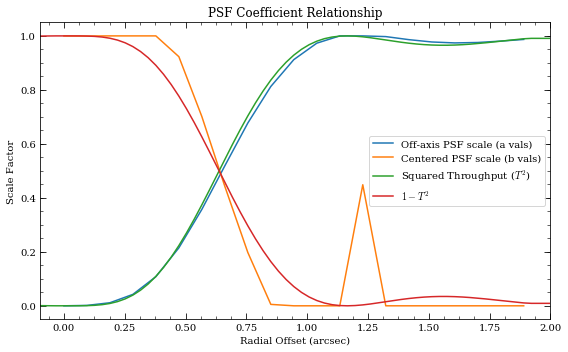

In [30]:
fig,ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(shift_asec, avals, label=r'Off-axis PSF scale (a vals)')
ax.plot(shift_asec, bvals, label=r'Centered PSF scale (b vals)')

#ax.plot(rad_bins[1:], rad_mn**2, label='Test')

nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)*pixscale
ax.plot(xv, mask[nx//2,:]**2, label=r'Squared Throughput ($T^2$)')
ax.plot(xv, 1-mask[nx//2,:]**2, label=r'$1-T^2$')

ax.set_xlim([-0.1,2])
ax.set_xlabel('Radial Offset (arcsec)')
ax.set_ylabel('Scale Factor')
ax.set_title('PSF Coefficient Relationship')



ax.legend()

fig.tight_layout()
#fig.savefig(outdir+'psf_coeff_relation.pdf')

3.46087077056e-07


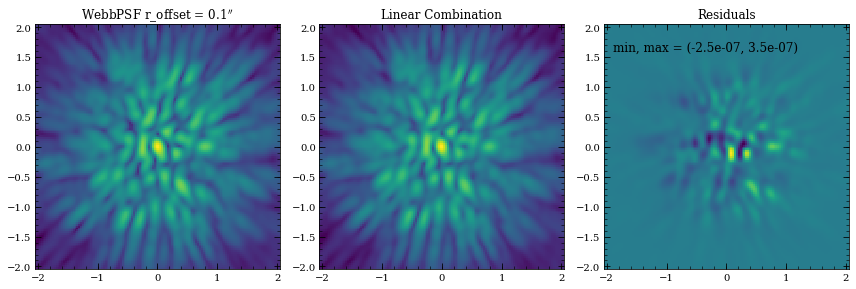

In [195]:
fig, ax = plt.subplots(1,3, figsize=(12,5))

i = 1

psf = psf_over_list[i]
ydata = nrc_utils.pad_or_cut_to_size(psf, psf_off_over.shape)
ymod = f(xdata, avals[i], bvals[i])
diff = ydata - ymod
print(np.abs(diff).max())

extent = np.array([-1,1,-1,1])*pixscale*ydata.shape[0]/2
ax[0].imshow(ydata**0.2, extent=extent)
ax[0].set_title(r'WebbPSF r_offset = {:.1f}$^{{\prime\prime}}$'.format(shift_asec[i]))
ax[1].imshow(ymod**0.2, extent=extent)
ax[1].set_title('Linear Combination')
ax[2].imshow(diff, extent=extent)
ax[2].set_title('Residuals')
mm_str = r'min, max = ({:.1e}, {:.1e})'.format(diff.min(),diff.max())
ax[2].text(-1.9, 1.6, mm_str, fontsize=12)

fig.tight_layout()
fig.savefig(outdir + 'psf_model.pdf')

# Bar Masks (y-offsets)

In [3]:
fov_pix = 129
oversample = 2

psf_info={'fov_pix':fov_pix, 'oversample':oversample,
          'save':False, 'force':True, 'jitter':None}


In [4]:
filt, pupil, pmask = ('F430M', 'WEDGELYOT', 'MASKLWB')
#filt, pupil, pmask = ('F430M', 'CIRCLYOT', 'MASK335R')

In [5]:
cf_ote = nrc_utils.psf_coeff(filt, **psf_info)
psf_ote, psf_ote_over = nrc_utils.gen_image_coeff(filt, coeff=cf_ote, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [6]:
cf_off = nrc_utils.psf_coeff(filt, pupil=pupil, **psf_info)
psf_off, psf_off_over = nrc_utils.gen_image_coeff(filt, pupil=pupil, coeff=cf_off, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [7]:
cf_cen = nrc_utils.psf_coeff(filt, pupil=pupil, mask=pmask, **psf_info)
psf_cen, psf_cen_over = nrc_utils.gen_image_coeff(filt, pupil=pupil, mask=pmask, coeff=cf_cen, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [8]:
fov_asec = fov_pix*nrc_utils.pixscale_LW
pixscale = nrc_utils.pixscale_LW / oversample

In [9]:
shift_array = np.arange(0,84,3)
shift_asec = shift_array * pixscale

In [10]:
def mshift(mask, shift_array):
    
    masks = []
    for shift in shift_array:
        mask_shift = nrc_utils.fshift(mask, dely=shift)
        mask_cut = nrc_utils.pad_or_cut_to_size(mask_shift, psf_ote_over.shape)
        masks.append(mask_cut)
    return masks

In [11]:
mask = nrc_utils.coron_trans(pmask, fov=2*fov_asec, pixscale=pixscale)
masks = mshift(mask, shift_array)

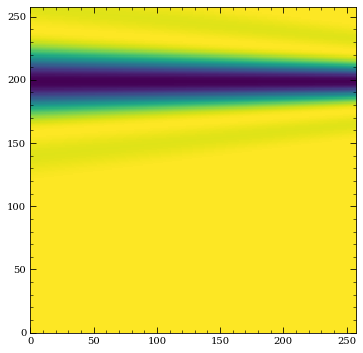

In [12]:
plt.imshow(masks[-5])

In [13]:
psf_list = []
psf_over_list = []
for i, offset in enumerate(shift_asec):
    print(shift_array[i])
    nrc = pynrc.NIRCam(filt, pupil=pupil, mask=pmask,
                       offset_r=offset, offset_theta=0, 
                       fov_pix=2*fov_pix+1, oversample=oversample,
                       force=True, save=False)
    psf0, psf1 = nrc.gen_psf(return_oversample=True)
    psf_list.append(psf0)
    psf_over_list.append(psf1)

0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81


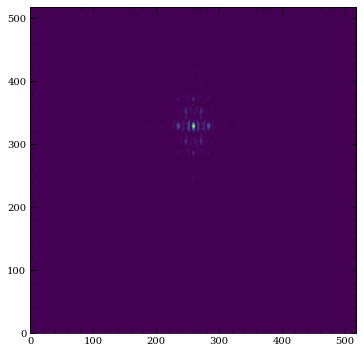

In [14]:
plt.imshow(psf_over_list[-5])

In [15]:
for i, psf in enumerate(psf_over_list):
    psf_list[i] = nrc_utils.fshift(psf_list[i], dely=-shift_array[i]/2)
    psf_over_list[i] = nrc_utils.fshift(psf_over_list[i], dely=-shift_array[i]*oversample/2)

In [16]:
masks[0].shape

(258, 258)

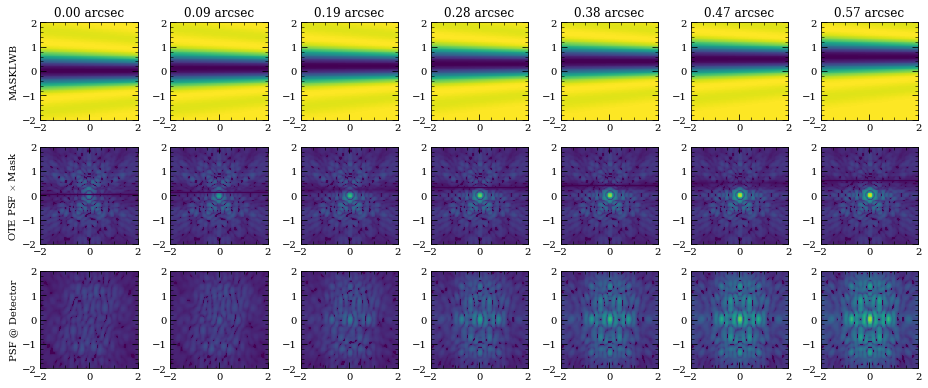

In [17]:
fig, axes = plt.subplots(3, 7, figsize=(13,5.5))

extent = np.array([-1,1,-1,1])*pixscale*masks[0].shape[0]/2
xylim = [-2,2]
for i, ax in enumerate(axes[0]):
    ax.imshow(masks[i], extent=extent)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel(pmask)
    ax.set_title('{:.2f} arcsec'.format(shift_asec[i]))

extent = np.array([-1,1,-1,1])*pixscale*psf_ote_over.shape[0]/2
for i, ax in enumerate(axes[1]):
    ax.imshow((masks[i]*psf_ote_over)**0.2, extent=extent, vmin=0, vmax=psf_ote_over.max()**0.2)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel(r'OTE PSF $\times$ Mask ')

extent = np.array([-1,1,-1,1])*pixscale*psf_over_list[0].shape[0]/2
for i, ax in enumerate(axes[2]):
    ax.imshow((psf_over_list[i]**0.2), extent=extent, vmin=0, vmax=psf_off_over.max()**0.2)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel('PSF @ Detector')

fig.tight_layout()

#outdir = '/Users/Jarron/Desktop/JWST-PP/'
#fig.savefig(outdir+'M335R_PSF_offset.pdf')

In [18]:
from pynrc.maths.image_manip import align_LSQ, fourier_imshift, fshift

In [19]:
from scipy.optimize import leastsq, least_squares
def f(x, a, b):
    return a*x[0] + b*x[1]

def residual(p, x, y):
    return (y - f(x, *p)).ravel()

In [26]:
nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)

xdata = np.array([nrc_utils.pad_or_cut_to_size(psf_off_over, (64,64)),
                  nrc_utils.pad_or_cut_to_size(psf_cen_over, (64,64))])


avals = []
bvals = []
for i, psf in enumerate(psf_over_list):
    #print(shift_array[i])
    #ydata = fshift(psf, -0.00957687, -0.01525233)
    ydata = nrc_utils.pad_or_cut_to_size(psf, (64,64))

    res_best = [0,0]
    chi_fin = 1e10
    a0 = np.interp(shift_array[i], xv, mask[:,nx//2]**2)
    b0 = 1-a0

    for a0 in np.linspace(0,1,10):
        b0 = 1-a0

        res = least_squares(residual, [a0,b0], args=(xdata, ydata), diff_step=0.1, 
                            bounds=([0,0],[1,1]))
        chi_new = np.sum((ydata - f(xdata, *res.x))**2)
        if chi_new < chi_fin:
            chi_fin = chi_new
            res_best = res.x

    ymod = f(xdata, *res_best)
    diff = ydata - ymod

    ydata_rebin = nrc_utils.frebin(ydata, scale=1/oversample)
    ymod_rebin = nrc_utils.frebin(ymod, scale=1/oversample)

    pnoise = np.sqrt(ymod_rebin)
    ind = ymod_rebin>0

    
    diff_rebin = ymod_rebin - ydata_rebin
    chi1 = np.sum((diff_rebin[ind])**2 / ymod_rebin[ind])
    chi2 = np.sum(diff_rebin[ind]**2 / pnoise[ind]**2)
    
    
    print(shift_array[i], chi1, chi2/ydata_rebin.sum(), np.abs(diff_rebin).max(), res_best)

                
    avals.append(res_best[0])
    bvals.append(res_best[1])

0 2.05828597093e-09 5.85825140675e-06 4.27780932911e-09 [  1.00000000e-10   1.00000000e+00]
3 6.86431147504e-05 0.145232491847 1.58152683195e-06 [ 0.00111446  1.        ]
6 0.000251272218372 0.149171542583 5.88098010011e-06 [ 0.01242868  1.        ]
9 0.000342748752419 0.0571415223142 1.12784277441e-05 [ 0.05376911  1.        ]
12 0.000353447635172 0.0231070698625 1.3936672003e-05 [ 0.14282677  0.91054065]
15 0.000328369289591 0.0109375944969 1.90272372814e-05 [ 0.28400259  0.57529733]
18 0.000305578792349 0.00628331945921 2.31976113061e-05 [  4.62382932e-01   3.56459535e-11]
21 0.000283679746373 0.00416686610353 2.97642595587e-05 [  6.48357349e-01   4.13405194e-11]
24 0.000268812634941 0.00316123649912 3.19421280147e-05 [  8.09863513e-01   7.65531180e-12]
27 0.000250788751963 0.00258310867171 2.96392174574e-05 [  9.24464293e-01   3.11466239e-11]
30 0.00022423977887 0.00216731250772 2.82219158174e-05 [  9.84896741e-01   6.31640393e-11]
33 0.000189078973817 0.00180179923651 2.6185268518

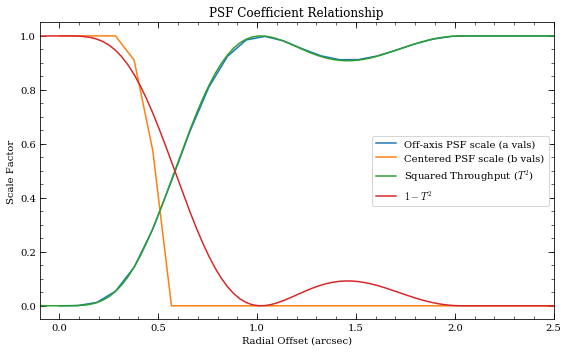

In [27]:
fig,ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(shift_asec, avals, label=r'Off-axis PSF scale (a vals)')
ax.plot(shift_asec, bvals, label=r'Centered PSF scale (b vals)')

nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)*pixscale
ax.plot(xv, mask[:,nx//2]**2, label=r'Squared Throughput ($T^2$)')
ax.plot(xv, 1-mask[:,nx//2]**2, label=r'$1-T^2$')

ax.set_xlim([-0.1,2.5])
ax.set_xlabel('Radial Offset (arcsec)')
ax.set_ylabel('Scale Factor')
ax.set_title('PSF Coefficient Relationship')



ax.legend()

fig.tight_layout()
#fig.savefig(outdir+'psf_coeff_relation.pdf')

5.7304313616e-06


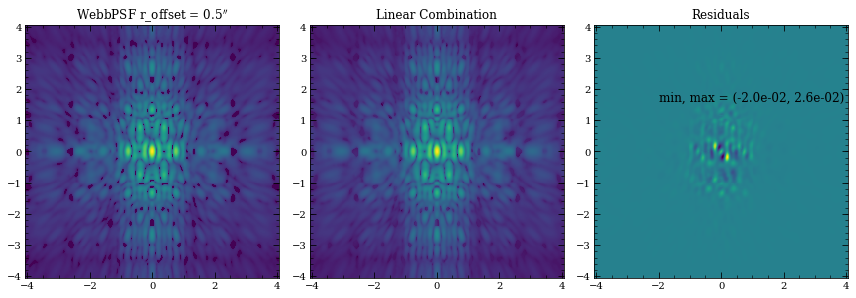

In [44]:
fig, ax = plt.subplots(1,3, figsize=(12,5))

i = 5

xdata = np.array([psf_off_over, psf_cen_over])
psf = psf_over_list[i]
ydata = nrc_utils.pad_or_cut_to_size(psf, psf_off_over.shape)
ymod = f(xdata, avals[i], bvals[i])
diff = ydata - ymod


extent = np.array([-1,1,-1,1])*pixscale*ydata.shape[0]/2
ax[0].imshow(ydata**0.2, extent=extent, vmin=0, vmax=ydata.max()**0.2)
ax[0].set_title(r'WebbPSF r_offset = {:.1f}$^{{\prime\prime}}$'.format(shift_asec[i]))
ax[1].imshow(ymod**0.2, extent=extent, vmin=0, vmax=ydata.max()**0.2)
ax[1].set_title('Linear Combination')
ax[2].imshow(diff, extent=extent)
ax[2].set_title('Residuals')

print(np.abs(diff).max())
mm_str = r'min, max = ({:.1e}, {:.1e})'.format(diff.min()/ydata.max(), diff.max()/ydata.max())
ax[2].text(-2, 1.6, mm_str, fontsize=12)

fig.tight_layout()
#fig.savefig(outdir + 'psf_model.pdf')

# Bar Masks (x-offsets)

In [45]:
fov_pix = 321
oversample = 2

psf_info={'fov_pix':fov_pix, 'oversample':oversample,
          'save':False, 'force':True, 'jitter':None}


In [46]:
filt, pupil, pmask = ('F430M', 'WEDGELYOT', 'MASKLWB')
#filt, pupil, pmask = ('F430M', 'CIRCLYOT', 'MASK335R')

In [47]:
cf_ote = nrc_utils.psf_coeff(filt, **psf_info)
psf_ote, psf_ote_over = nrc_utils.gen_image_coeff(filt, coeff=cf_ote, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [48]:
cf_off = nrc_utils.psf_coeff(filt, pupil=pupil, **psf_info)
psf_off, psf_off_over = nrc_utils.gen_image_coeff(filt, pupil=pupil, coeff=cf_off, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [49]:
cf_cen = nrc_utils.psf_coeff(filt, pupil=pupil, mask=pmask, **psf_info)
psf_cen, psf_cen_over = nrc_utils.gen_image_coeff(filt, pupil=pupil, mask=pmask, coeff=cf_cen, 
                                                  fov_pix=fov_pix, oversample=oversample, 
                                                  return_oversample=True)

In [50]:
fov_asec = fov_pix*nrc_utils.pixscale_LW
pixscale = nrc_utils.pixscale_LW / oversample

In [51]:
shift_array = np.arange(-288,300,12)
shift_asec = shift_array * pixscale
print(shift_asec)

[-9.072 -8.694 -8.316 -7.938 -7.56  -7.182 -6.804 -6.426 -6.048 -5.67
 -5.292 -4.914 -4.536 -4.158 -3.78  -3.402 -3.024 -2.646 -2.268 -1.89
 -1.512 -1.134 -0.756 -0.378  0.     0.378  0.756  1.134  1.512  1.89
  2.268  2.646  3.024  3.402  3.78   4.158  4.536  4.914  5.292  5.67
  6.048  6.426  6.804  7.182  7.56   7.938  8.316  8.694  9.072]


In [52]:
def mshift(mask, shift_array):
    
    masks = []
    for shift in shift_array:
        mask_shift = nrc_utils.fshift(mask, delx=-shift)
        mask_cut = nrc_utils.pad_or_cut_to_size(mask_shift, psf_ote_over.shape)
        masks.append(mask_cut)
    return masks

In [53]:
mask = nrc_utils.coron_trans(pmask, fov=2*fov_asec, pixscale=pixscale)
masks = mshift(mask, shift_array)

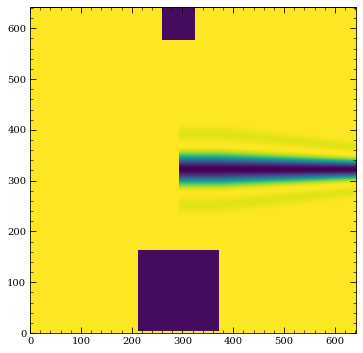

In [54]:
plt.imshow(masks[0])

In [55]:
psf_list = []
psf_over_list = []
for i, offset in enumerate(shift_asec):
    print(shift_array[i])
    nrc = pynrc.NIRCam(filt, pupil=pupil, mask=pmask,
                       offset_r=offset, offset_theta=-90, 
                       fov_pix=401, oversample=oversample,
                       force=True, save=False)
    psf0, psf1 = nrc.gen_psf(return_oversample=True)
    psf_list.append(psf0)
    psf_over_list.append(psf1)

-288
-276
-264
-252
-240
-228
-216
-204
-192
-180
-168
-156
-144
-132
-120
-108
-96
-84
-72
-60
-48
-36
-24
-12
0
12
24
36
48
60
72
84
96
108
120
132
144
156
168
180
192
204
216
228
240
252
264
276
288


In [67]:
for psf in psf_over_list:
    print(psf.sum())

0.000929899502904
0.000655601217736
0.000589881409118
0.000581210804035
0.000576469029499
0.000584598935378
0.000589703335049
0.000600464638097
0.000617502627508
0.000632037910593
0.00064749362343
0.000663552713959
0.000678640793259
0.000694920798644
0.000711755608652
0.000728470417181
0.000743875399487
0.000759508022841
0.000775264273251
0.000790473926099
0.000805272544284
0.000820035379083
0.000834964247473
0.000849554099701
0.000864214192864
0.000879321557171
0.00089491397791
0.00091178342029
0.000928758703071
0.000946865256414
0.000967035152522
0.000989410328189
0.00101453485719
0.00104233273472
0.00107469954162
0.00111402527368
0.00116069135197
0.00121519135318
0.00127833343263
0.0013489656389
0.00143515402303
0.0015385760487
0.00164884367894
0.00178825867833
0.00190580326624
0.00196549437049
0.00194559507961
0.00188884230529
0.00195929491477


In [56]:
for i, psf in enumerate(psf_over_list):
    psf_list[i] = nrc_utils.fshift(psf_list[i], delx=-shift_array[i]/2)
    psf_over_list[i] = nrc_utils.fshift(psf_over_list[i], delx=-shift_array[i]*oversample/2)

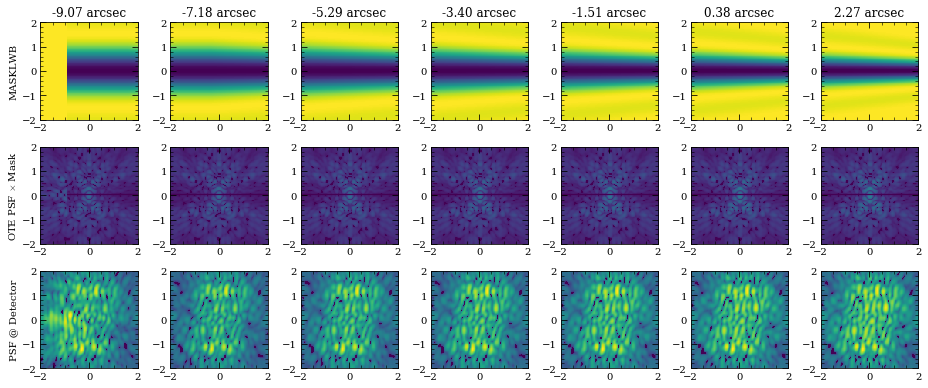

In [57]:
fig, axes = plt.subplots(3, 7, figsize=(13,5.5))

extent = np.array([-1,1,-1,1])*pixscale*masks[0].shape[0]/2
xylim = [-2,2]
for i, ax in enumerate(axes[0]):
    ii = 5*i
    ax.imshow(masks[ii], extent=extent)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel(pmask)
    ax.set_title('{:.2f} arcsec'.format(shift_asec[ii]))

extent = np.array([-1,1,-1,1])*pixscale*psf_ote_over.shape[0]/2
for i, ax in enumerate(axes[1]):
    ii = 5*i
    ax.imshow((masks[ii]*psf_ote_over)**0.2, extent=extent, vmin=0, vmax=psf_ote_over.max()**0.2)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel(r'OTE PSF $\times$ Mask ')

extent = np.array([-1,1,-1,1])*pixscale*psf_over_list[0].shape[0]/2
for i, ax in enumerate(axes[2]):
    ii = 5*i
    ax.imshow((psf_over_list[ii]**0.2), extent=extent, vmin=0, vmax=psf_cen_over.max()**0.2)
    ax.set_xlim(xylim)
    ax.set_ylim(xylim)
    if i==0: ax.set_ylabel('PSF @ Detector')

fig.tight_layout()

#outdir = '/Users/Jarron/Desktop/JWST-PP/'
#fig.savefig(outdir+'M335R_PSF_offset.pdf')

In [58]:
from pynrc.maths.image_manip import align_LSQ, fourier_imshift, fshift

In [66]:
from astropy.modeling import models, fitting


ny,nx = masks[0].shape
xv = (np.arange(nx)-nx/2)*pixscale
yv = (np.arange(ny)-ny/2)*pixscale

sig_list = []
for m in masks:
    mv = m[:,nx//2]
    
    ind_temp = mv>0.98
    ind = np.abs(yv) < np.min(np.abs(yv[ind_temp]))

    g_init = models.Gaussian1D(amplitude=1., mean=0, stddev=1.)
    fit_g = fitting.LevMarLSQFitter()
    g = fit_g(g_init, yv[ind], 1-mv[ind])

    sig_list.append(np.abs(g.stddev.value))
    
sig_vals = np.array(sig_list)

In [67]:
sig_vals

array([ 0.55280954,  0.55280954,  0.55280954,  0.55280954,  0.55280954,
        0.54531164,  0.53552937,  0.52642864,  0.51733518,  0.50825392,
        0.4984565 ,  0.4893701 ,  0.4802936 ,  0.47050988,  0.46141812,
        0.45233359,  0.44325709,  0.43345467,  0.42436237,  0.41528029,
        0.40549023,  0.39639468,  0.38731081,  0.37823936,  0.36843818,
        0.35935062,  0.35027467,  0.34048617,  0.33139043,  0.32230645,
        0.31323569,  0.30342661,  0.2943352 ,  0.28525909,  0.27546773,
        0.26637073,  0.25729035,  0.24822809,  0.23841545,  0.22932605,
        0.22025461,  0.21045879,  0.20135645,  0.19227792,  0.18405778,
        0.18405778,  0.18405778,  0.18405778,  0.18405778])

In [71]:
from scipy.optimize import leastsq, least_squares
def f(x, a, b, c):
    return a*x[0] + b*x[1] + c*x[2]

def residual(p, x, y):
    return ((y - f(x, *p))**1).ravel()

In [72]:

nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)

xdata = np.array([nrc_utils.pad_or_cut_to_size(psf_over_list[5], (64,64)),
                  nrc_utils.pad_or_cut_to_size(psf_cen_over, (64,64)),
                  nrc_utils.pad_or_cut_to_size(psf_over_list[-6], (64,64))]) * 1e5

avals = []
bvals = []
cvals = []

res0_1 = []
res0_2 = []


for i, psf in enumerate(psf_over_list):
    #print(shift_array[i])
    #ydata = fshift(psf, -0.00957687, -0.01525233)
    #ydata = nrc_utils.pad_or_cut_to_size(psf, psf_off_over.shape)
    ydata = nrc_utils.pad_or_cut_to_size(psf, (64,64))*1e5

    res_best = [0,0]
    chi_fin = 1e10

    for b0 in np.linspace(0,2,10):
        a0= (2-b0)/2
        c0= 2 - a0 - b0 
        
        res = least_squares(residual, [a0, b0, c0], args=(xdata, ydata), diff_step=0.01,
                            bounds=([0,0,0],[2,2,2]), method='trf', verbose=0)

        chi_new = np.sum((ydata - f(xdata, *res.x))**2)
        if chi_new < chi_fin:
            chi_fin = chi_new
            res_best = res.x

    ymod = f(xdata, *res_best) / 1e5
    ydata /= 1e5
    diff = ydata - ymod

    ydata_rebin = nrc_utils.frebin(ydata, scale=1/oversample)
    ymod_rebin = nrc_utils.frebin(ymod, scale=1/oversample)

    pnoise = np.sqrt(ymod_rebin)
    ind = ymod_rebin>0

    
    diff_rebin = ymod_rebin - ydata_rebin
    chi1 = np.sum((diff_rebin[ind])**2 / ymod_rebin[ind])
    chi2 = np.sum(diff_rebin[ind]**2 / pnoise[ind]**2)
    
    
    print(shift_array[i], chi1, chi1/ydata_rebin.sum(), np.abs(diff_rebin).max(), res_best)

    
    #print(shift_array[i], np.abs(diff_rebin**2).sum(), np.abs(diff_rebin).max(), res_best)
                
    avals.append(res_best[0])
    bvals.append(res_best[1])
    cvals.append(res_best[2])
    
    res0_1.append(np.abs(diff_rebin**2).sum())
    res0_2.append(np.abs(diff_rebin).max())

-288 0.0012062192272 3.65167169671 2.52855643764e-06 [  1.09638144e+00   5.63496511e-18   4.68178270e-02]
-276 2.9553175399e-05 0.140823051514 3.97851556038e-07 [  1.00941380e+00   3.12663721e-20   2.36501633e-03]
-264 6.11634351657e-06 0.0318056818069 1.32500862583e-07 [  9.55826799e-01   4.16155302e-11   5.78949724e-10]
-252 1.10953717334e-06 0.00566583025441 8.77840427138e-08 [  9.64551759e-01   3.98874324e-20   2.39172112e-03]
-240 7.89493976175e-07 0.00402118823484 6.09774050573e-08 [  9.68540432e-01   3.77174798e-03   2.06992548e-15]
-228 3.14815120558e-11 1.56653908508e-07 2.0026016671e-10 [  9.99851293e-01   8.22426180e-15   4.65346354e-05]
-216 3.31574707265e-07 0.00160818230978 3.28602930181e-08 [ 0.98885205  0.01933602  0.00146486]
-204 3.7928682258e-07 0.00179169988994 4.18431969614e-08 [  9.73406527e-01   4.68991312e-02   4.11077876e-16]
-192 3.35399324915e-07 0.00152836127893 3.96283114856e-08 [  9.81528373e-01   6.46447984e-02   3.40538577e-13]
-180 4.09344530958e-07 0.0

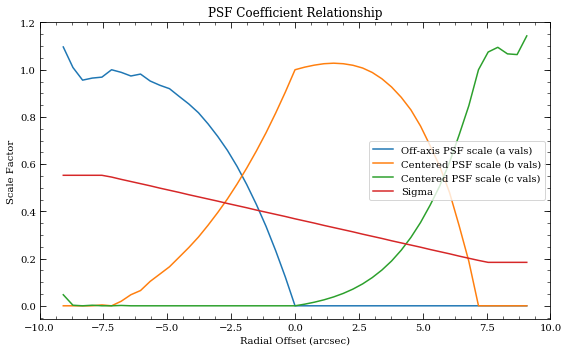

In [73]:
fig,ax = plt.subplots(1,1, figsize=(8,5))

ax.plot(shift_asec, avals, label=r'Off-axis PSF scale (a vals)')
ax.plot(shift_asec, bvals, label=r'Centered PSF scale (b vals)')
ax.plot(shift_asec, cvals, label=r'Centered PSF scale (c vals)')

ax.plot(shift_asec, sig_vals, label=r'Sigma')

nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)*pixscale
#ax.plot(xv, mask[:,nx//2]**2, label=r'Squared Throughput ($T^2$)')
#ax.plot(xv, 1-mask[:,nx//2]**2, label=r'$1-T^2$')

ax.set_xlim([-10,10])
ax.set_xlabel('Radial Offset (arcsec)')
ax.set_ylabel('Scale Factor')
ax.set_title('PSF Coefficient Relationship')



ax.legend()

fig.tight_layout()
#fig.savefig(outdir+'psf_coeff_relation.pdf')

In [75]:
psf_over_list[5].shape

(802, 802)

In [76]:
psf_cen_over.shape

(642, 642)

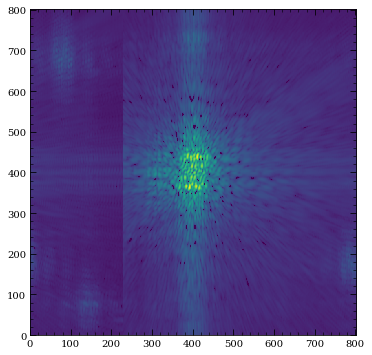

In [81]:
plt.imshow(psf_over_list[5]**0.2)

1.07664603187e-07


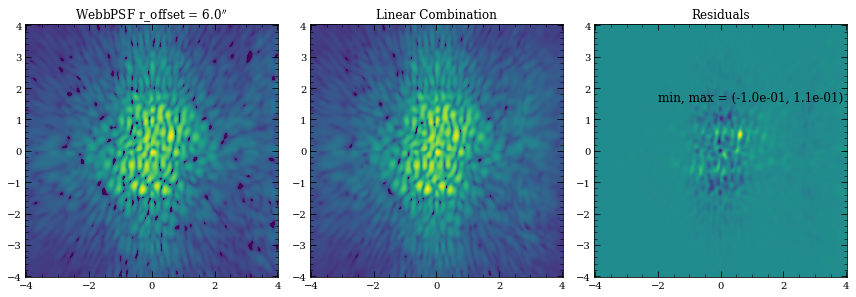

In [84]:
fig, ax = plt.subplots(1,3, figsize=(12,5))

i = 40

sh = (256,256)

xdata = np.array([pad_or_cut_to_size(psf_over_list[5], sh),
                  pad_or_cut_to_size(psf_cen_over, sh),
                  pad_or_cut_to_size(psf_over_list[-6], sh)])

psf = psf_over_list[i]
ydata = pad_or_cut_to_size(psf, sh)
ymod = f(xdata, avals[i], bvals[i], cvals[i])
diff = ydata - ymod


extent = np.array([-1,1,-1,1])*pixscale*ydata.shape[0]/2
ax[0].imshow(ydata**0.2, extent=extent, vmin=0, vmax=ydata.max()**0.2)
ax[0].set_title(r'WebbPSF r_offset = {:.1f}$^{{\prime\prime}}$'.format(shift_asec[i]))
ax[1].imshow(ymod**0.2, extent=extent, vmin=0, vmax=ydata.max()**0.2)
ax[1].set_title('Linear Combination')
ax[2].imshow(diff, extent=extent)
ax[2].set_title('Residuals')

print(np.abs(diff).max())
mm_str = r'min, max = ({:.1e}, {:.1e})'.format(diff.min()/ydata.max(), diff.max()/ydata.max())
ax[2].text(-2, 1.6, mm_str, fontsize=12)

fig.tight_layout()
#fig.savefig(outdir + 'psf_model.pdf')

In [64]:

nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)

xdata = np.array([nrc_utils.pad_or_cut_to_size(psf_over_list[5], (64,64)),
                  nrc_utils.pad_or_cut_to_size(psf_cen_over, (64,64)),
                  nrc_utils.pad_or_cut_to_size(psf_over_list[-6], (64,64))]) * 1e5

avals = []
bvals = []
cvals = []

res0_1 = []
res0_2 = []


for i, psf in enumerate(psf_over_list):
    #print(shift_array[i])
    #ydata = fshift(psf, -0.00957687, -0.01525233)
    #ydata = nrc_utils.pad_or_cut_to_size(psf, psf_off_over.shape)
    ydata = nrc_utils.pad_or_cut_to_size(psf, (64,64))*1e5

    res_best = [0,0]
    chi_fin = 1e10

    for a0 in np.linspace(0,2,10):
        b0= (2 - a0) / 2
        c0= 2 - a0 - b0 
        
        res = least_squares(residual, [a0, 0, c0], args=(xdata, ydata), diff_step=0.01,
                            bounds=([0,0,0],[2,1e-10,2]), method='trf', verbose=0)

        chi_new = np.sum((ydata - f(xdata, *res.x))**2)
        if chi_new < chi_fin:
            chi_fin = chi_new
            res_best = res.x

    ymod = f(xdata, *res_best) / 1e5
    ydata /= 1e5
    diff = ydata - ymod

    ydata_rebin = nrc_utils.frebin(ydata, scale=1/oversample)
    ymod_rebin = nrc_utils.frebin(ymod, scale=1/oversample)

    pnoise = np.sqrt(ymod_rebin)
    ind = ymod_rebin>0

    
    diff_rebin = ymod_rebin - ydata_rebin
    chi1 = np.sum((diff_rebin[ind])**2 / ymod_rebin[ind])
    chi2 = np.sum(diff_rebin[ind]**2 / pnoise[ind]**2)
    
    
    print(shift_array[i], chi1, chi1/ydata_rebin.sum(), np.abs(diff_rebin).max(), res_best)

                
    avals.append(res_best[0])
    bvals.append(res_best[1])
    cvals.append(res_best[2])
    
    res0_1.append(np.abs(diff_rebin**2).sum())
    res0_2.append(np.abs(diff_rebin).max())

-288 0.00120621922606 3.65167169324 2.52855643758e-06 [  1.09638144e+00   9.15560302e-21   4.68178272e-02]
-276 2.95531748746e-05 0.140823049015 3.97851557465e-07 [  1.00941379e+00   2.15348209e-19   2.36501987e-03]
-264 6.11634353958e-06 0.0318056819265 1.32500862835e-07 [  9.55826802e-01   3.14771407e-13   3.07768314e-14]
-252 1.10953717396e-06 0.00566583025754 8.77840335177e-08 [  9.64551746e-01   3.93892134e-19   2.39172524e-03]
-240 7.91277858089e-07 0.00403027421292 6.09829109171e-08 [  9.74575263e-01   9.98701634e-11   6.05772684e-05]
-228 2.6108722105e-17 1.29918580679e-13 3.04992529746e-16 [  1.00000000e+00   4.99999277e-11   4.99996239e-11]
-216 3.49499294348e-07 0.00169511898869 3.26419149556e-08 [  1.01544453e+00   9.99979886e-11   3.13517560e-03]
-204 4.67508928414e-07 0.00220844924135 4.14004044667e-08 [  1.03943696e+00   9.99999829e-11   3.57226277e-03]
-192 4.80060079331e-07 0.00218755728563 4.40281718711e-08 [  1.07104007e+00   9.99999975e-11   5.39435792e-03]
-180 7.5

In [69]:
from scipy.optimize import leastsq, least_squares
def f(x, a, b):#, c):
    return a*x[0] + b*x[1] #+ c*x[2]

def residual(p, x, y):
    return ((y - f(x, *p))**1).ravel()

In [70]:

nx = mask.shape[0]
xv = (np.arange(nx)-nx/2)

xdata = np.array([nrc_utils.pad_or_cut_to_size(psf_over_list[5], (64,64)),
                  nrc_utils.pad_or_cut_to_size(psf_over_list[-6], (64,64))])

sig_data = sig_vals**0.5
sig_data = sig_data - sig_data.min()
sig_data = sig_data / sig_data.max()

res2_1 = []
res2_2 = []
for i, psf in enumerate(psf_over_list):
    ydata = nrc_utils.pad_or_cut_to_size(psf, (64,64))
    
    a0 = sig_data[i]
    b0 = 1-a0
    
    res_best = (a0, b0)

    ymod = f(xdata, *res_best)
    diff = ydata - ymod
    
    ydata_rebin = 1e10 * nrc_utils.frebin(ydata, scale=1/oversample)
    ymod_rebin = 1e10 * nrc_utils.frebin(ymod, scale=1/oversample)

    pnoise = np.sqrt(ymod_rebin)
    ind = ymod_rebin>0
    
    diff_rebin = ymod_rebin - ydata_rebin
    chi1 = np.sum((diff_rebin[ind])**2 / ymod_rebin[ind])
    chi2 = np.sum(diff_rebin[ind]**2 / pnoise[ind]**2)
    
    print(shift_array[i], chi1, chi1/ydata_rebin.sum(), np.abs(diff_rebin).max(), res_best)
    
    res2_1.append(np.abs(diff_rebin**2).sum())
    res2_2.append(np.abs(diff_rebin).max())

-288 21374074.3117 6.47072277137 25905.1009496 (1.0, 0.0)
-276 307021.931635 0.146298205559 4005.2727181 (1.0, 0.0)
-264 62189.9825371 0.0323394981134 1295.26518775 (1.0, 0.0)
-252 12277.7539051 0.00626961143825 802.963593492 (1.0, 0.0)
-240 8770.44106698 0.00446711380925 681.5826065 (1.0, 0.0)
-228 10941.1120151 0.00544436352851 821.932569208 (0.9839123608630187, 0.016087639136981302)
-216 39251.6674397 0.0190375911741 1573.84486016 (0.96275612197599891, 0.037243878024001087)
-204 73547.1506949 0.0347426838899 2553.64690753 (0.942899656073524, 0.057100343926476005)
-192 106912.333785 0.0487182468954 3395.36402117 (0.92288686946264542, 0.077113130537354579)
-180 143678.738323 0.0633181493624 4072.50778397 (0.90272463013985338, 0.097275369860146621)
-168 190662.88663 0.0814317387753 5096.50025933 (0.88076929292590611, 0.11923070707409389)
-156 232942.263568 0.0962535998165 6024.06709193 (0.86021364281544077, 0.13978635718455923)
-144 278511.202446 0.111602604228 6902.48707313 (0.8394889

In [227]:
psf_cen.sum()

0.00085409808259865683

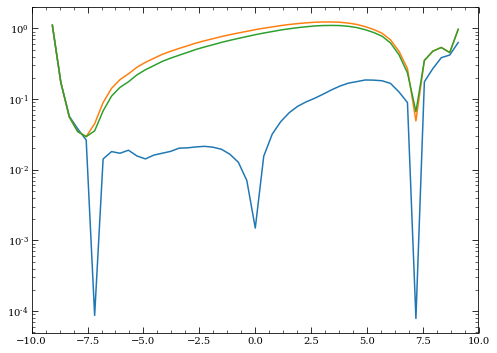

In [224]:
plt.semilogy(shift_asec, np.array(res0_2) / np.abs(psf_cen).max())
plt.semilogy(shift_asec, np.array(res1_2) / np.abs(psf_cen).max())
plt.semilogy(shift_asec, np.array(res2_2) / np.abs(psf_cen).max())

#plt.ylim([1e-9,1e-5])
#plt.semilogy(shift_asec, res1_2)
#plt.semilogy(shift_asec, res2_2)

(1e-09, 1e-05)

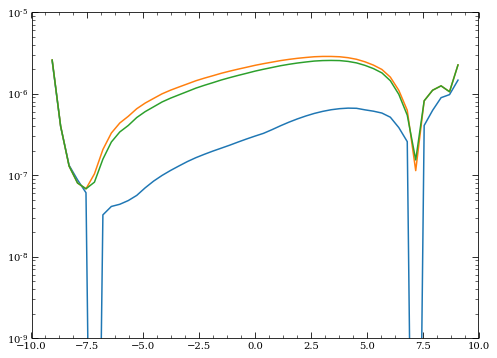

In [216]:
plt.semilogy(shift_asec, res0_2)
plt.semilogy(shift_asec, res1_2)
plt.semilogy(shift_asec, res2_2)

plt.ylim([1e-9,1e-5])
#plt.semilogy(shift_asec, res1_2)
#plt.semilogy(shift_asec, res2_2)

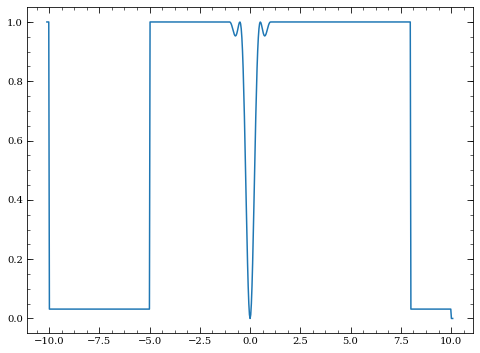

In [184]:
plt.plot(yv, m[:,nx//2])
#plt.plot(xv, 1-g(xv))

In [ ]:
def func_opt(params, xdata, ydata):
    model = xdata[0] * params[0] + ydata[0] * params[1]
    return ydata - model

res = least_squares(shift_subtract, init_pars, diff_step=0.1,
                    loss='soft_l1', f_scale=1.0, args=(reference,target), 
                    kwargs={'mask':mask,'pad':pad,'shift_function':shift_function})


In [86]:
res.x

array([ 0.94831125,  0.73049707])

In [ ]:

def func_opt(params, xdata, ydata):
    model = xdata[0] * params[0] + ydata[0] * params[1]
    return ydata - model
    #return (ydata - numpy.dot(xdata, params))


leastsq(func, x0, args=(xdata, ydata))